# RISM - A Gentle Introduction

We are going to write a Python implementation of the extended RISM equation with the goal of computing the direct, indirect and total correlation function along with the radial distribution function.

First, we import the libraries we will be needing:

In [17]:
import numpy as np
from scipy.fftpack import dstn, idstn
from scipy.special import erf
import matplotlib.pyplot as plt

First, we need to set up our problem domain. While the RISM equations are written as continuous functions $r$ (e.g. $c(r)$), computationally we solve them on a discretised grid.

We'll set up a discrete domain of length (or radius since we are working with spherically symmetric functions) $r = 15\, Å$ partitioned into $N = 100$ points. The resulting grid spacing is given by $\Delta r = \frac{r}{N}$.

In [18]:
r = 15.0
N = 500
dr = r / N

We also want to set up a grid spacing for our Fourier-space grid such that $\Delta r \Delta k = \frac{\pi}{N}$

In [19]:
dk = 2.0 * np.pi / (2.0 * N * dr)

Lets check the equality we stated above:

In [20]:
np.isclose(dr * dk, np.pi / N)

True

We use `np.isclose()` here because we are comparing floating point numbers. Using `==` would not work since there is always some precision loss with floats. You need to compared them within tolerances instead.

We can use these to generate our real and Fourier-space midpoint grids.

In [21]:
r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

## Water - A System of Interest

Water

In [22]:
T = 298.15 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

Programmatically

In [23]:
ns = 3

ow_eps = 78.15 * kB
ow_sigma = 3.16572
ow_charge = -0.8476

hw_eps = 7.815 * kB
hw_sigma = 1.16572
hw_charge = 0.4238

dens = 0.0334

rho = np.diag([dens, dens, dens])

params = [ [ow_eps, ow_sigma, ow_charge], [hw_eps, hw_sigma, hw_charge], [hw_eps, hw_sigma, hw_charge] ]

coords = [ np.array([0.0, 0.0, 0.0]), np.array([1.0, 0.0, 0.0]), np.array([-0.333314, 0.942816, 0.0])]

In [24]:
def dist_matrix(coords):
    ns = len(coords)
    dist = np.zeros((ns, ns))
    for i, j in np.ndindex((ns, ns)):
        dist[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist

In [25]:
def wk(coords, k):
    dists = dist_matrix(coords)
    out = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        dist_ij = dists[i, j]
        if dist_ij == 0.0:
            out[:, i, j] = np.ones(N)
        else:
            out[:, i, j] = np.sin(k * dist_ij) / (k * dist_ij)
    return out

water_wk = wk(coords, k_grid)

In [26]:
ec = 1.602176565e-19 # A*s
eps_0 = 8.854187817620e-12 # A^2*s^4/kg/m^3
Na = 6.02214129e23 # 1 / mol
kc = 1.0 / 4.0 / np.pi/ eps_0 # J*m/A^2/s^2
kc_a = kc * 1e10 # J*angstrom/A^2/s^2
kc_akj = kc_a * 1e-3 # kJ*angstrom/A^2/s^2
kc_akjmol = kc_akj * Na # kJ*angstrom/A^2/s^2/mol
lb = ec * ec * kc_akjmol # kJ*angstrom/mol

def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

def Coulomb(q, r):
    return lb * q / r

from scipy.special import erf

def Ng_real(q, r):
    return lb * q * erf(r) / r

def Ng_fourier(q, k):
    return 4.0 * np.pi * lb * q * np.exp(-np.power(k, 2.0) / 4.0) / np.power(k, 2.0)

In [27]:
def lorentz_berthelot(eps1, eps2, sig1, sig2):
    return np.sqrt(eps1 * eps2), 0.5 * (sig1 + sig2)

In [28]:
def energy(params, r):
    out = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        eps, sig = lorentz_berthelot(
            params[i][0], params[j][0], params[i][1], params[j][1]
        )
        q = params[i][2] * params[j][2]
        out[:, i, j] = LJ(eps, sig, r) + Coulomb(q, r)

    return out

In [29]:
def renorm(params, r, k):
    out_r = np.zeros((N, ns, ns))
    out_k = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        q = params[i][2] * params[j][2]
        out_r[:, i, j] = Ng_real(q, r)
        out_k[:, i, j] = Ng_fourier(q, k)

    return out_r, out_k

In [30]:
ur = energy(params, r_grid)
ur_lr, uk_lr = renorm(params, r_grid, k_grid)

ur_sr = ur - ur_lr

In [31]:
def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

def PY(beta, ur, tr):
    return np.exp(-beta * ur) * (1.0 + tr) - 1.0 - tr

def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r[:, np.newaxis, np.newaxis], type=4, axes=[0]) / k[:, np.newaxis, np.newaxis]

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k[:, np.newaxis, np.newaxis], type=4, axes=[0]) / r[:, np.newaxis, np.newaxis]

def RISM(cr, vk_lr, w, p, r, k, dr, dk):
    N = r.shape[0]
    
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)

    ck -= vk_lr

    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        A = np.linalg.inv(I - p @ w[l] @ ck[l])
        B = w[l] @ ck[l] @ w[l]
        tk[l] = A @ B - ck[l]
    
    tk -= vk_lr
    
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

def picard_iteration(tolerance, max_step, alpha, initial_tr, beta, ur_sr, uk_lr,  wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ur_sr, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, beta * uk_lr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        # Since we set alpha = 1.0 above, this is 
        # essentially direct iteration (tr_new = f_tr).
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the absolute value of the difference between the current and previous solution
        # We use .max() because we want to check that all values are below the tolerance, and
        # if the maximum value of the difference array is below, then so must the other values be.
        diff = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            print("Final Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

In [32]:
tolerance = 1e-7
max_step = 10000
alpha = 0.7
initial_tr = np.zeros((N, ns, ns))
lambdas = 1

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print(lam)
    tr = picard_iteration(tolerance, max_step, alpha, initial_tr, beta, lam * ur_sr, lam * uk_lr, water_wk, rho)
    initial_tr = tr


cr = HNC(beta, ur_sr, tr) - beta * ur_lr
tr += beta * ur_lr

1.0
Iteration: 0 Diff: 8.90e+00


Iteration: 100 Diff: 4.26e-01
Iteration: 200 Diff: 1.36e-01
Iteration: 300 Diff: 4.04e-02
Iteration: 400 Diff: 1.11e-02
Iteration: 500 Diff: 2.99e-03
Iteration: 600 Diff: 7.98e-04
Iteration: 700 Diff: 2.12e-04
Iteration: 800 Diff: 5.65e-05
Iteration: 900 Diff: 1.50e-05
Iteration: 1000 Diff: 4.00e-06
Iteration: 1100 Diff: 1.06e-06
Iteration: 1200 Diff: 2.82e-07
Final Iteration: 1279 Diff: 9.92e-08


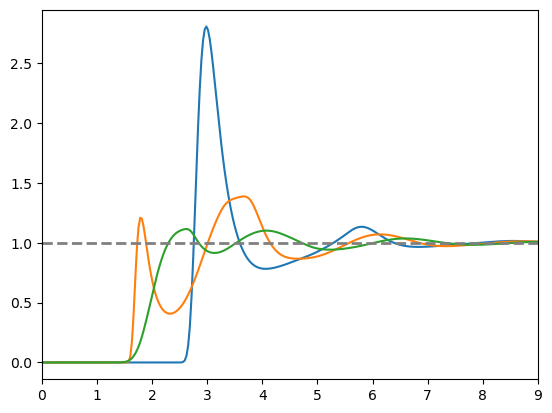

In [33]:
hr = tr + cr

gr = hr + 1.0

plt.plot(r_grid, gr[:, 0, 0])
plt.plot(r_grid, gr[:, 0, 1])
plt.plot(r_grid, gr[:, 1, 1])
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.xlim([0, 9])
plt.show()